# Computing energy transfers from simulation

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import glob
from scipy import signal
import niskine 

import mplniw.utils as ut
import mplniw.plot as pl
import mplniw.sigp as sp
import gsw
import pandas as pd
import cmocean as cm

In [2]:
conf = niskine.io.load_config()
m1lon, m1lat, m1bottom_depth = niskine.io.mooring_location(mooring=1)
m2lon, m2lat, m2bottom_depth = niskine.io.mooring_location(mooring=2)
m3lon, m3lat, m3bottom_depth = niskine.io.mooring_location(mooring=3)
root_dir = '/Users/zcasparcohen/codes/NIW/data/'
figdir='/Users/zcasparcohen/codes/NIW/figures_vid/'

In [3]:
ds = xr.open_dataset(root_dir+'niskine_mooring.nc')
grid= xr.open_dataset(root_dir+'niskine_mooring_grid.nc')

In [4]:
t0,t1 = '2001-01-06T16:00:00','2001-01-29T15:00:16'
t_storm = '2001-01-08'

In [5]:
time = np.arange(np.datetime64(t0), np.datetime64(t1), np.timedelta64(1, "h"))

In [6]:
#ds.time.dtype
ds=ds.assign_coords({'time':time})

/var/folders/vl/tj6snrv54zd212pkvk5g_l140000gn/T/ipykernel_22341/2379562032.py:2: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds=ds.assign_coords({'time':time})
/var/folders/vl/tj6snrv54zd212pkvk5g_l140000gn/T/ipykernel_22341/2379562032.py:2: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray

In [7]:
ds['lat_u'] = grid.lat_u
ds['lat_v'] = grid.lat_v
ds['lon_u'] = grid.lon_u
ds['lon_v'] = grid.lon_v
ds['lat_rho'] = grid.lat_rho
ds['lon_rho'] = grid.lon_rho
ds['eta_rho'] = grid.eta_rho
ds['xi_rho'] = grid.xi_rho
ds['eta_v'] = grid.eta_v
ds['xi_u'] = grid.xi_u

In [8]:
ds["lat_u"]=ds.lat_u.assign_coords({'eta_u':ds.eta_u})
ds["lon_u"]=ds.lon_u.assign_coords({'eta_u':ds.eta_u})

In [9]:
ds["lat_v"]=ds.lat_v.assign_coords({'xi_v':ds.xi_v})
ds["lon_v"]=ds.lon_v.assign_coords({'xi_v':ds.xi_v})

In [10]:
def u2rho(var_u):
    K,N,M,L = var_u.shape
    if M>L:
        Lp=L+1;
        Lm=L-1;
        var_rho=np.zeros((K,N,M,Lp));
        var_rho[:,:,:, 1:L] = 0.5 * (var_u[:,:,:, 0:Lm] + var_u[:,:,:, 1:L])
        var_rho[:,:,:, 0] = var_rho[:,:,:, 1]
        var_rho[:,:,:, Lp-1] = var_rho[:,:,:, L-1]
    elif L>M:
        Mp=M+1;
        Mm=M-1;
        var_rho=var_rho=np.zeros((K,N,Mp,L));
        var_rho[:,:,1:M,:] = 0.5 * (var_u[:,:,0:Mm,:] + var_u[:,:,1:M,:])
        var_rho[:,:,0,:] = var_rho[:,:,1,:]
        var_rho[:,:,Mp-1,:] = var_rho[:,:,M-1,:]
    else:
        print('Check var_u shape')
    return var_rho

In [11]:
u_rho = xr.apply_ufunc(u2rho,ds.u, input_core_dims=[['time','depth','eta_rho','xi_u']],output_core_dims=[['time','depth','eta_rho','xi_rho']])
v_rho = xr.apply_ufunc(u2rho,ds.v, input_core_dims=[['time','depth','eta_v','xi_rho']],output_core_dims=[['time','depth','eta_rho','xi_rho']])

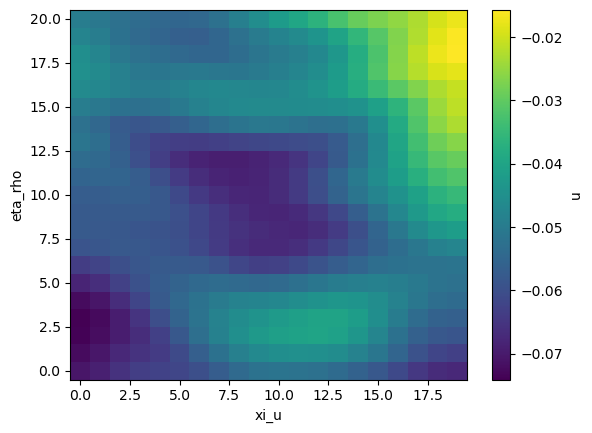

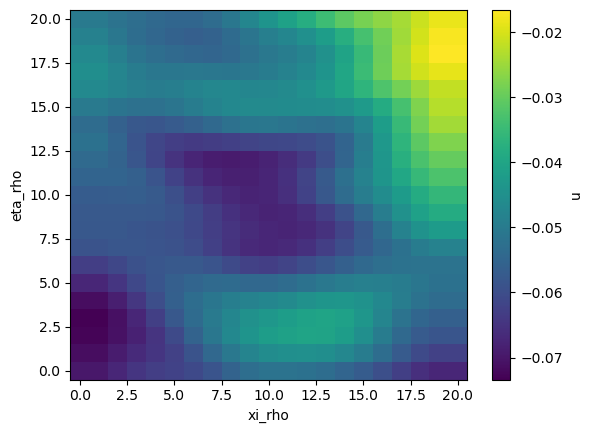

In [12]:
ds.u.mean(['time','depth']).plot()
plt.figure()
u_rho.mean(['time','depth']).plot()

In [13]:
u_rho = u_rho.assign_coords({'lat':ds.lat_rho,'lon':ds.lon_rho,'x':grid.x_rho,'y':grid.y_rho})
v_rho = v_rho.assign_coords({'lat':ds.lat_rho,'lon':ds.lon_rho,'x':grid.x_rho,'y':grid.y_rho})

In [14]:
ke = 0.5*(u_rho**2+v_rho**2)

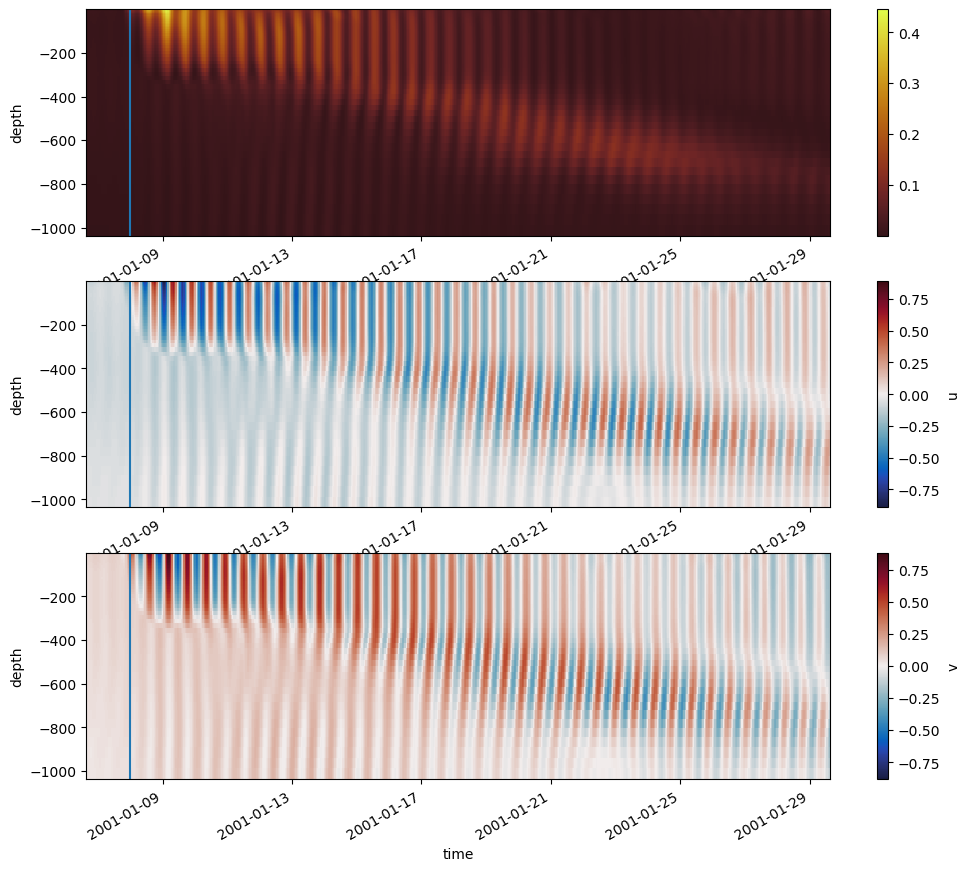

In [15]:
fig,ax=plt.subplots(3,1,figsize=(12,10))
ke.mean(['eta_rho','xi_rho']).plot(ax=ax[0],y='depth',cmap=cm.cm.solar)
u_rho.mean(['eta_rho','xi_rho']).plot(ax=ax[1],y='depth',cmap=cm.cm.balance)
v_rho.mean(['eta_rho','xi_rho']).plot(ax=ax[2],y='depth',cmap=cm.cm.balance)
for a in ax:
    a.axvline(np.datetime64(t_storm))

In [16]:
# Circle radius around moorings
R=gsw.distance([m1lon,m2lon],[m1lat,m2lat])/(2*np.sin(60*np.pi/180))
#Coordinates of the center of the mooring array 
latitudes = [m*np.pi/180 for m in [m1lat,m2lat,m3lat]]
longitudes = [m*np.pi/180 for m in [m1lon,m2lon,m3lon]]
sumx = np.sum(np.cos(latitudes)*np.cos(longitudes))/3
sumy = np.sum(np.cos(latitudes)*np.sin(longitudes))/3
sumz = np.sum(np.sin(latitudes))/3
midlon = 180*np.arctan2(sumy,sumx)/np.pi
hyp = np.sqrt(sumx*sumx+sumy*sumy)
midlat = 180*np.arctan2(sumz,hyp)/np.pi

In [17]:
import cartopy.crs as ccrs


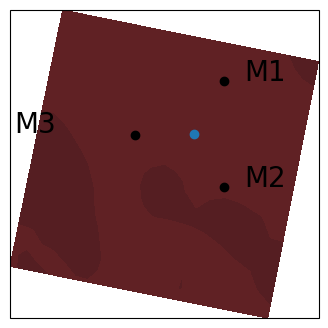

In [18]:
subplot_kws=dict(projection=ccrs.LambertConformal(central_longitude=-20.0,central_latitude=60.0),
                     facecolor='white')
    
fig=plt.figure(figsize=[4,4])
p = ke.mean(['time']).isel(depth=0).plot.contourf(x='lon', y='lat',
                      vmin=0, vmax=5e-1,
                      cmap=cm.cm.solar,
                      subplot_kws=subplot_kws,
                      transform=ccrs.PlateCarree(),
                      levels=30,
                      add_labels=False,
                      add_colorbar=False)
    
p.axes.scatter([m1lon,m2lon,m3lon],[m1lat,m2lat,m3lat],c='k', transform=ccrs.PlateCarree())
p.axes.text(m1lon+0.05,m1lat, 'M1',size=20,transform=ccrs.PlateCarree());p.axes.text(m2lon+0.05,m2lat, 'M2',size=20,transform=ccrs.PlateCarree());
p.axes.text(m3lon-0.3,m3lat, 'M3',size=20,transform=ccrs.PlateCarree());
p.axes.scatter(midlon,midlat, transform=ccrs.PlateCarree());

In [149]:
for i,t in enumerate(u_rho.time[:]):
    subplot_kws=dict(projection=ccrs.LambertConformal(central_longitude=-20.0,central_latitude=60.0),
                     facecolor='white')
    
    fig=plt.figure(figsize=[4,4])
    p = ke.sel(time=t).isel(depth=0).plot.contourf(x='lon', y='lat',
                      vmin=0, vmax=5e-1,
                      cmap=cm.cm.solar,
                      subplot_kws=subplot_kws,
                      transform=ccrs.PlateCarree(),
                      levels=30,
                      add_labels=False,
                      add_colorbar=False)
    
    p.axes.scatter([m1lon,m2lon,m3lon],[m1lat,m2lat,m3lat],c='k', transform=ccrs.PlateCarree())
    p.axes.text(m1lon+0.05,m1lat, 'M1',size=20,transform=ccrs.PlateCarree());p.axes.text(m2lon+0.05,m2lat, 'M2',size=20,transform=ccrs.PlateCarree());
    p.axes.text(m3lon-0.3,m3lat, 'M3',size=20,transform=ccrs.PlateCarree());
    p.axes.scatter(midlon,midlat, transform=ccrs.PlateCarree());
    plt.title(t.values)
    plt.savefig(figdir+'t_%s'%i)
    fig.clear();

/var/folders/vl/tj6snrv54zd212pkvk5g_l140000gn/T/ipykernel_11297/2250940910.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig=plt.figure(figsize=[4,4])


<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

In [51]:
#Definition filter
dt = 1/24  # Time step in days unit
signal='lp'
Tw = 30  # Kernel length
if signal=='bp':
    omega = ut.coriolis(lat)*3600*24/(2*np.pi)  # Central frequency
    bandwidth = 0.2
    h = ut.generate_filter(omega,dt=dt,T=Tw,bandwidth=bandwidth,lat=lat,pass_zero=False)  # Best filter
elif signal=='lp':
    fc=ut.coriolis(midlat)*3600*24/(2*np.pi)  # Coriolis frequency
    omega = 1/(fc-0.3)  #Cutoff frequency
    bandwidth = None 
    h = ut.generate_filter(omega,dt=dt,T=Tw,bandwidth=bandwidth,lat=midlat,pass_zero=True)  # Best filter
else:
    print('Filter not defined')
h_hat, w = ut.filter_response(h, dt=dt)  #Filter response

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


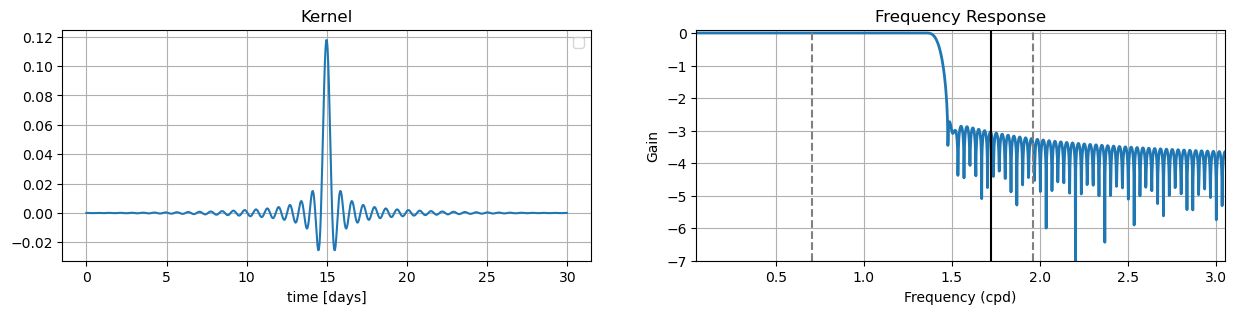

In [52]:
#Plot filter and response in the frequency domain
t = np.arange(0,Tw,dt)
fig, axes = plt.subplots(1,2, figsize=(15,3))
ax = axes[0]
ax.plot(t, h)
ax.grid()
ax.set_xlabel('time [days]')
ax.set_title('Kernel')
ax.legend()

ax = axes[1]

ax.plot(w, np.log10(abs(h_hat)), linewidth=2)
ax.axvline(fc, color='k')
#ax.axvline(omega-bandwidth, color='k',ls='--')
#ax.axvline(omega+bandwidth, color='k',ls='--')
ax.axvline(1.96, color='grey', ls='--')
ax.axvline(omega, color='grey', ls='--')
ax.set_xlabel('Frequency (cpd)')
ax.set_ylabel('Gain')
ax.set_title('Frequency Response')
#ax.set_ylim(-0.05, 1.05)
ax.set_ylim(-7, 0.1)
ax.set_xlim(0.05, 3.05)
ax.grid(True)

In [53]:
ds_rho = xr.Dataset({'u':u_rho,'v':v_rho,'ke':ke})
ds_rho

<xarray.Dataset>
Dimensions:  (depth: 54, time: 552, eta_rho: 21, xi_rho: 21)
Coordinates:
  * depth    (depth) float32 -2.0 -5.0 -9.0 -13.0 ... -914.0 -962.0 -1.012e+03
  * time     (time) datetime64[ns] 2001-01-06T16:00:00 ... 2001-01-29T15:00:00
  * eta_rho  (eta_rho) int64 0 1 2 3 4 5 6 7 8 9 ... 12 13 14 15 16 17 18 19 20
  * xi_rho   (xi_rho) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20
    lat      (eta_rho, xi_rho) float64 58.86 58.86 58.85 ... 59.13 59.13 59.13
    lon      (eta_rho, xi_rho) float64 -21.72 -21.69 -21.66 ... -21.0 -20.97
    x        (eta_rho, xi_rho) float64 1.269e+06 1.271e+06 ... 1.293e+06
    y        (eta_rho, xi_rho) float64 1.205e+06 1.205e+06 ... 1.242e+06
Data variables:
    u        (time, depth, eta_rho, xi_rho) float64 -0.1673 -0.1673 ... -0.08486
    v        (time, depth, eta_rho, xi_rho) float64 -0.0179 ... -0.06428
    ke       (time, depth, eta_rho, xi_rho) float64 0.01415 0.01406 ... 0.005666

In [54]:
ds_rho['usq'] = ds_rho.u**2
ds_rho['vsq'] = ds_rho.v**2
ds_rho['uv'] = ds_rho.u*ds_rho.v
col = ['u','v','vsq','usq','uv']

In [59]:
#Apply filter
ds_filt = sp.wrap_filter(ds_rho.transpose("depth","eta_rho", "xi_rho", "time"),h,columns=col)

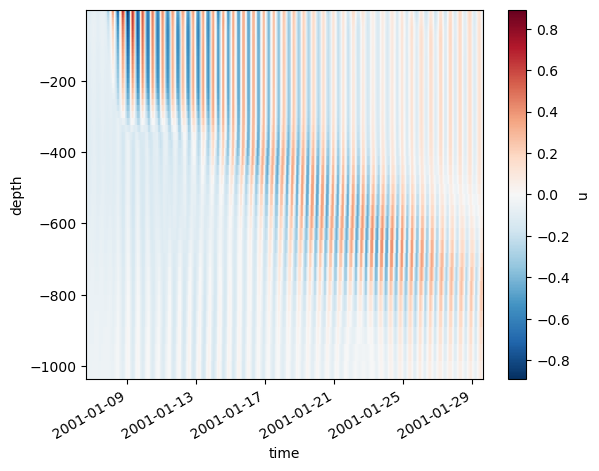

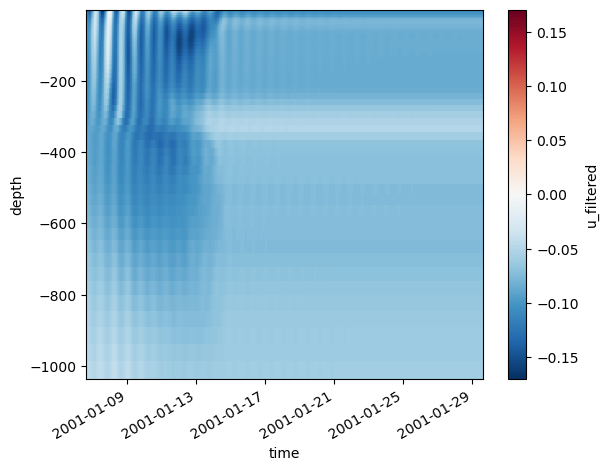

In [60]:
ds_filt.u.mean(['eta_rho','xi_rho']).plot()
plt.figure()
ds_filt.u_filtered.mean(['eta_rho','xi_rho']).plot()

In [61]:
PI_1 = (ds_filt.usq_filtered-ds_filt.u_filtered**2)*ds_filt.u_filtered.diff('x')
PI_2 = (ds_filt.vsq_filtered-ds_filt.v_filtered**2)*ds_filt.v_filtered.diff('y')
PI_3 = (ds_filt.uv_filtered-ds_filt.u_filtered*ds_filt.v_filtered)*(ds_filt.u_filtered.diff('y')+ds_filt.v_filtered.diff('x'))
PI_omega = -(PI_1+PI_2+PI_3)

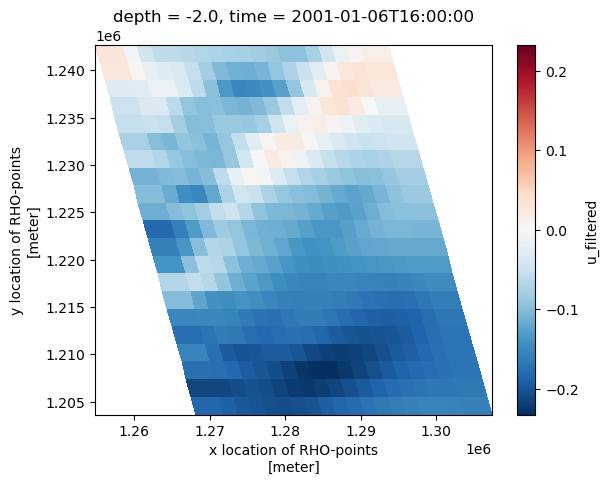

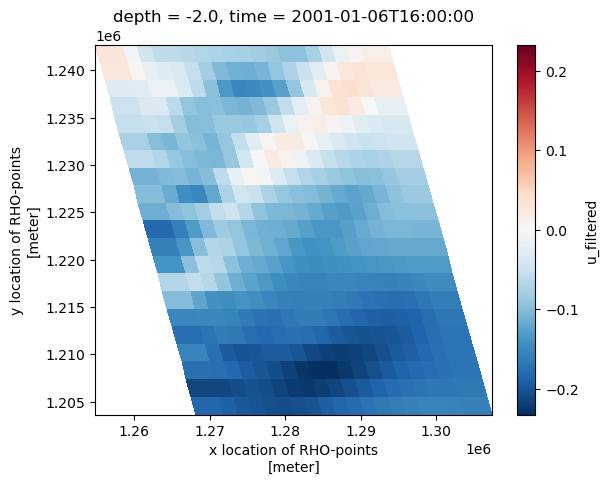

In [62]:
ds_filt.u_filtered.diff('x').isel(time=0,depth=0).plot(x='x',y='y')
plt.figure()
ds_filt.u_filtered.isel(time=0,depth=0).plot(x='x',y='y')

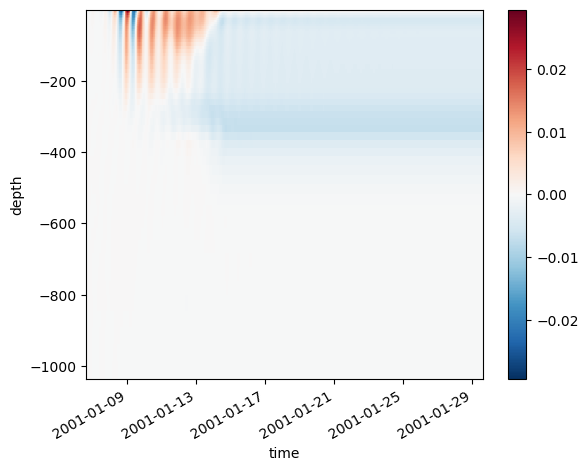

In [63]:
PI_omega.mean(['eta_rho','xi_rho']).plot()

In [64]:
dl=0.008
M1 = ds_filt.where((ds_filt.lat<m1lat+dl)&(ds_filt.lat>m1lat-dl),drop=True
                  ).where((ds_filt.lon<m1lon+dl)&(ds_filt.lon>m1lon-dl),drop=True)
M2 = ds_filt.where((ds_filt.lat<m2lat+dl)&(ds_filt.lat>m2lat-dl),drop=True
                  ).where((ds_filt.lon<m3lon+dl)&(ds_filt.lon>m3lon-dl),drop=True)

PI_M1 = PI_omega.where((PI_omega.lat<m1lat+dl)&(PI_omega.lat>m1lat-dl),drop=True
                  ).where((PI_omega.lon<m1lon+dl)&(PI_omega.lon>m1lon-dl),drop=True)
PI_M2 = PI_omega.where((PI_omega.lat<m2lat+dl)&(PI_omega.lat>m2lat-dl),drop=True
                  ).where((PI_omega.lon<m2lon+dl)&(PI_omega.lon>m2lon-dl),drop=True)
dl=0.01
M3 = ds_filt.where((ds_filt.lat<m3lat+dl)&(ds_filt.lat>m3lat-dl),drop=True
                  ).where((ds_filt.lon<m3lon+dl)&(ds_filt.lon>m3lon-dl),drop=True)
PI_M3 = PI_omega.where((PI_omega.lat<m3lat+dl)&(PI_omega.lat>m3lat-dl),drop=True
                  ).where((PI_omega.lon<m3lon+dl)&(PI_omega.lon>m3lon-dl),drop=True)

In [65]:
print(M1.u.lat.values,M1.u.lon.values)
print(m1lat,m1lon)

print(M2.u.lat.values,M2.u.lon.values)
print(m2lat,m2lon)

print(M3.u.lat.values,M3.u.lon.values)
print(m3lat,m3lon)

[[59.09999016]
 [59.11636437]] [[-21.20615912]
 [-21.2002115 ]]
59.101445324829214 -21.198829621395166
[[58.95105588]
 [58.96751521]
 [58.98396597]] [[-21.42505717]
 [-21.41912935]
 [-21.41319887]]
58.96598147489824 -21.196656975200398
[[59.03632341]
 [59.05273985]
 [59.06914774]] [[-21.42730623]
 [-21.42136366]
 [-21.4154184 ]]
59.030217712396855 -21.417375289217556


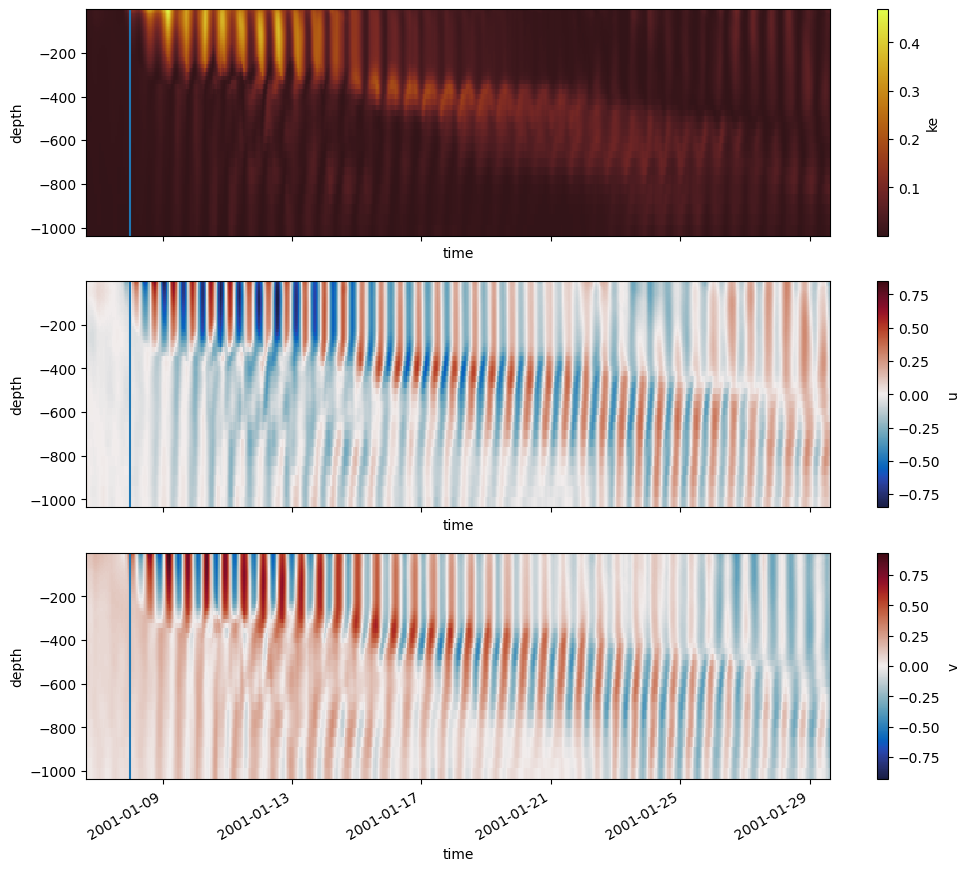

In [66]:
fig,ax=plt.subplots(3,1,figsize=(12,10),sharex=True)
M1.ke.mean(['eta_rho','xi_rho']).plot(ax=ax[0],y='depth',cmap=cm.cm.solar)
M1.u.mean(['eta_rho','xi_rho']).plot(ax=ax[1],y='depth',cmap=cm.cm.balance)
M1.v.mean(['eta_rho','xi_rho']).plot(ax=ax[2],y='depth',cmap=cm.cm.balance)
for a in ax:
    a.axvline(np.datetime64(t_storm))

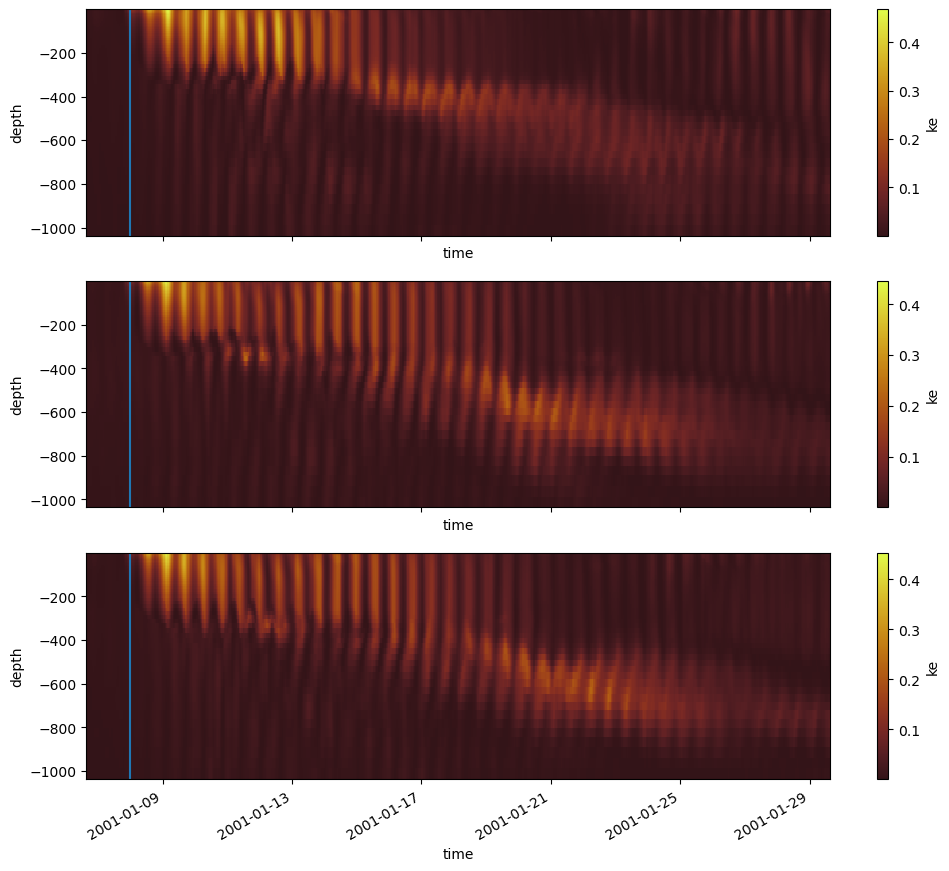

In [67]:
fig,ax=plt.subplots(3,1,figsize=(12,10),sharex=True)
M1.ke.mean(['eta_rho','xi_rho']).plot(ax=ax[0],y='depth',cmap=cm.cm.solar)
M2.ke.mean(['eta_rho','xi_rho']).plot(ax=ax[1],y='depth',cmap=cm.cm.solar)
M3.ke.mean(['eta_rho','xi_rho']).plot(ax=ax[2],y='depth',cmap=cm.cm.solar)
for a in ax:
    a.axvline(np.datetime64(t_storm))

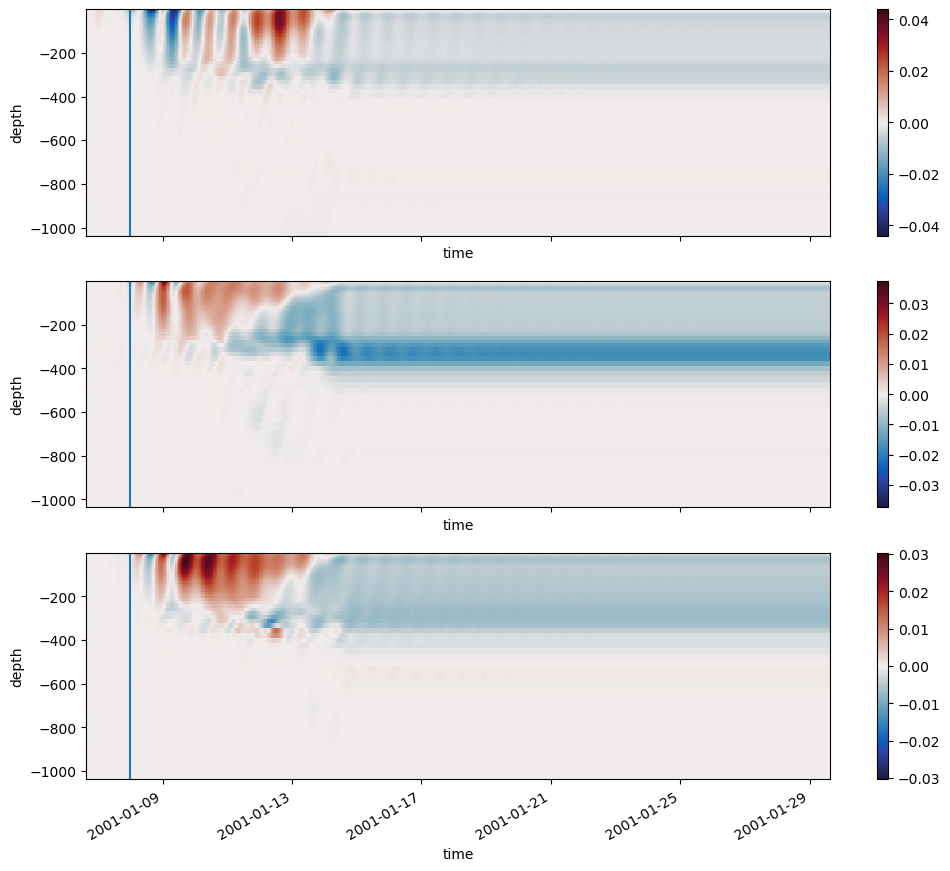

In [68]:
fig,ax=plt.subplots(3,1,figsize=(12,10),sharex=True)
PI_M1.mean(['eta_rho','xi_rho']).plot(ax=ax[0],y='depth',cmap=cm.cm.balance)
PI_M2.mean(['eta_rho','xi_rho']).plot(ax=ax[1],y='depth',cmap=cm.cm.balance)
PI_M3.mean(['eta_rho','xi_rho']).plot(ax=ax[2],y='depth',cmap=cm.cm.balance)
for a in ax:
    a.axvline(np.datetime64(t_storm))

In [69]:
# Computing distance and horizontal gradients (triangle approximation)
dx_NE = gsw.distance([midlon,m1lon],[midlat,midlat])
dx_SE = gsw.distance([midlon,m2lon],[midlat,midlat])
dx_SW = gsw.distance([midlon,m3lon],[midlat,midlat])
dx_NW = gsw.distance([midlon,m3lon],[midlat,midlat])

dy_NE = gsw.distance([midlon,midlon],[midlat,m1lat])
dy_SE = gsw.distance([midlon,midlon],[midlat,m2lat])
#dy_SW = gsw.distance([midlon,midlon],[midlat,m2lat])
#dy_NW = gsw.distance([midlon,midlon],[midlat,m3lat])

In [70]:
dy_NE

array([7656.4241041])

In [71]:
ueast = (M1.u_filtered.mean(['eta_rho','xi_rho'])*dy_SE+M2.u_filtered.mean(['eta_rho','xi_rho'])*dy_NE)/(dy_NE+dy_SE)
veast = (M1.v_filtered.mean(['eta_rho','xi_rho'])*dy_SE+M2.v_filtered.mean(['eta_rho','xi_rho'])*dy_NE)/(dy_NE+dy_SE)

uwest = M3.u_filtered.mean(['eta_rho','xi_rho'])
vwest = M3.v_filtered.mean(['eta_rho','xi_rho'])

unorth = M1.u_filtered.mean(['eta_rho','xi_rho'])
vnorth = M1.v_filtered.mean(['eta_rho','xi_rho'])

usouth = M2.u_filtered.mean(['eta_rho','xi_rho'])
vsouth = M2.v_filtered.mean(['eta_rho','xi_rho'])

ux = (ueast-uwest)/((dx_NE+dx_SE+dx_NW+dx_SW)/2)
vx = (veast-vwest)/((dx_NE+dx_SE+dx_NW+dx_SW)/2)
uy = (unorth-usouth)/((dy_NE+dy_SE))
vy = (vnorth-vsouth)/((dy_NE+dy_SE))

RV = vx-uy

In [73]:
moorings = {'1':M1,'2':M2,'3':M3}

In [74]:
M_mid = ds_filt.where((ds_filt.lat<midlat+dl)&(ds_filt.lat>midlat-dl),drop=True
                  ).where((ds_filt.lon<midlon+dl)&(ds_filt.lon>midlon-dl),drop=True).mean(['eta_rho','xi_rho'])

In [75]:
P = -((M_mid.usq_filtered-M_mid.u_filtered**2)*ux + (M_mid.vsq_filtered-M_mid.v_filtered**2
                                                    )*vy + (M_mid.uv_filtered-M_mid.u_filtered*M_mid.v_filtered)*(uy+vx))

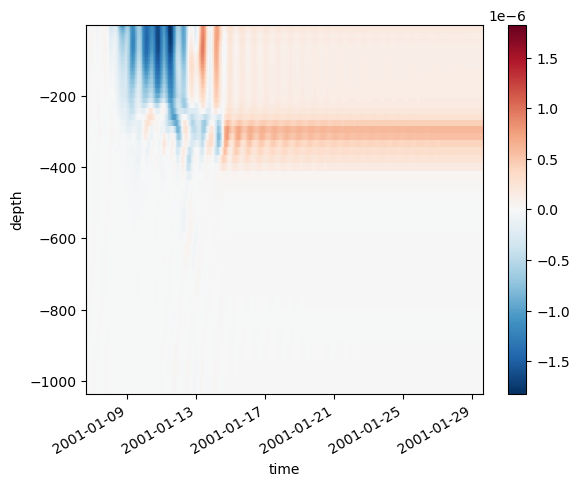

In [76]:
P.plot()

In [77]:
def select_point(ds,PI,dl,lat,lon):
    M = ds.where((ds.lat<lat+dl)&(ds.lat>lat-dl),drop=True
                      ).where((ds.lon<lon+dl)&(ds.lon>lon-dl),drop=True)
    PI_M = PI.where((PI.lat<lat+dl)&(PI.lat>lat-dl),drop=True
                      ).where((PI.lon<lon+dl)&(PI.lon>lon-dl),drop=True)
    return M,PI_M

In [78]:
M1, PI_M1 = select_point(ds_filt,PI_omega,0.008,m1lat,m1lon)
M2, PI_M2 = select_point(ds_filt,PI_omega,0.008,m2lat,m2lon)
M3, PI_M3 = select_point(ds_filt,PI_omega,0.01,m2lat,m3lon)
M4, PI_M4 = select_point(ds_filt,PI_omega,0.05,m1lat,m3lon)

In [79]:
midlon,midlat=(m3lon+m1lon)/2,(m2lat+m1lat)/2

In [80]:
# Computing distance and horizontal gradients (triangle approximation)
dx_NE = gsw.distance([midlon,m1lon],[midlat,midlat])
dx_SE = gsw.distance([midlon,m2lon],[midlat,midlat])
dx_SW = gsw.distance([midlon,m3lon],[midlat,midlat])
dx_NW = gsw.distance([midlon,m3lon],[midlat,midlat])

dy_NE = gsw.distance([midlon,midlon],[midlat,m1lat])
dy_SE = gsw.distance([midlon,midlon],[midlat,m2lat])
dy_SW = gsw.distance([midlon,midlon],[midlat,m2lat])
dy_NW = gsw.distance([midlon,midlon],[midlat,m1lat])

In [81]:
d_NE = gsw.distance([midlon,m1lon],[midlat,m1lat])
d_SE = gsw.distance([midlon,m2lon],[midlat,m2lat])
d_SW = gsw.distance([midlon,m3lon],[midlat,m2lat])
d_NW = gsw.distance([midlon,m3lon],[midlat,m1lat])

In [82]:
moorings={'1':M1,'2':M2,'3':M3,'4':M4}

In [83]:
ueast = (moorings['1'].u_filtered.mean(['eta_rho','xi_rho'])*dy_SE+moorings['2'].u_filtered.mean(['eta_rho','xi_rho'])*dy_NE)/(dy_NE+dy_SE)
veast = (moorings['1'].v_filtered.mean(['eta_rho','xi_rho'])*dy_SE+moorings['2'].v_filtered.mean(['eta_rho','xi_rho'])*dy_NE)/(dy_NE+dy_SE)

uwest = (moorings['3'].u_filtered.mean(['eta_rho','xi_rho'])*dy_SW+moorings['4'].u_filtered.mean(['eta_rho','xi_rho'])*dy_NW)/(dy_NW+dy_SW)
vwest = (moorings['3'].v_filtered.mean(['eta_rho','xi_rho'])*dy_SW+moorings['4'].v_filtered.mean(['eta_rho','xi_rho'])*dy_NW)/(dy_NW+dy_SW)

unorth = (moorings['1'].u_filtered.mean(['eta_rho','xi_rho'])*dx_NW+moorings['4'].u_filtered.mean(['eta_rho','xi_rho'])*dx_NE)/(dx_NE+dx_NW)
vnorth = (moorings['1'].v_filtered.mean(['eta_rho','xi_rho'])*dx_NW+moorings['4'].v_filtered.mean(['eta_rho','xi_rho'])*dx_NE)/(dx_NE+dx_NW)

usouth = (moorings['2'].u_filtered.mean(['eta_rho','xi_rho'])*dx_SW+moorings['3'].u_filtered.mean(['eta_rho','xi_rho'])*dx_SE)/(dx_SE+dx_SW)
vsouth = (moorings['2'].v_filtered.mean(['eta_rho','xi_rho'])*dx_SW+moorings['3'].v_filtered.mean(['eta_rho','xi_rho'])*dx_SE)/(dx_SE+dx_SW)

In [84]:
uc = (M1.u_filtered.mean(['eta_rho','xi_rho'])/d_NE+M2.u_filtered.mean(['eta_rho','xi_rho'])/d_SE+M3.u_filtered.mean(['eta_rho','xi_rho'])/d_SW+M4.u_filtered.mean(['eta_rho','xi_rho'])/d_NW
     )/(1/d_NE+1/d_SE+1/d_SW+1/d_NW)
vc = (M1.v_filtered.mean(['eta_rho','xi_rho'])/d_NE+M2.v_filtered.mean(['eta_rho','xi_rho'])/d_SE+
      M3.v_filtered.mean(['eta_rho','xi_rho'])/d_SW+M4.v_filtered.mean(['eta_rho','xi_rho'])/d_NW)/(1/d_NE+1/d_SE+1/d_SW+1/d_NW)
usqc = (M1.usq_filtered.mean(['eta_rho','xi_rho'])/d_NE+M2.usq_filtered.mean(['eta_rho','xi_rho'])/d_SE+
        M3.usq_filtered.mean(['eta_rho','xi_rho'])/d_SW+M4.usq_filtered.mean(['eta_rho','xi_rho'])/d_NW)/(1/d_NE+1/d_SE+1/d_SW+1/d_NW)

vsqc = (M1.vsq_filtered.mean(['eta_rho','xi_rho'])/d_NE+M2.vsq_filtered.mean(['eta_rho','xi_rho'])/d_SE+
        M3.vsq_filtered.mean(['eta_rho','xi_rho'])/d_SW+M4.vsq_filtered.mean(['eta_rho','xi_rho'])/d_NW)/(1/d_NE+1/d_SE+1/d_SW+1/d_NW)

uvc = (M1.uv_filtered.mean(['eta_rho','xi_rho'])/d_NE+M2.uv_filtered.mean(['eta_rho','xi_rho'])/d_SE+
       M3.uv_filtered.mean(['eta_rho','xi_rho'])/d_SW+M4.uv_filtered.mean(['eta_rho','xi_rho'])/d_NW)/(1/d_NE+1/d_SE+1/d_SW+1/d_NW)

In [85]:
ux_1 = (ueast-uwest)/((dx_NE+dx_SE+dx_NW+dx_SW)/2)
vx_1 = (veast-vwest)/((dx_NE+dx_SE+dx_NW+dx_SW)/2)
uy_1 = (unorth-usouth)/((dy_NW+dy_SW+dy_NE+dy_SE)/2)
vy_1 = (vnorth-vsouth)/((dy_NW+dy_SW+dy_NE+dy_SE)/2)

In [86]:
RV_1 = vx_1-uy_1

In [87]:
M_mid = ds_filt.where((ds_filt.lat<midlat+dl)&(ds_filt.lat>midlat-dl),drop=True
                  ).where((ds_filt.lon<midlon+dl)&(ds_filt.lon>midlon-dl),drop=True).mean(['eta_rho','xi_rho'])
P_mid = -((M_mid.usq_filtered-M_mid.u_filtered**2)*ux_1 + (M_mid.vsq_filtered-M_mid.v_filtered**2
                                                    )*vy_1 + (M_mid.uv_filtered-M_mid.u_filtered*M_mid.v_filtered)*(uy_1+vx_1))
P = -((usqc-uc**2)*ux_1 + (vsqc-vc**2)*vy_1 + (uvc-uc*vc)*(uy_1+vx_1))

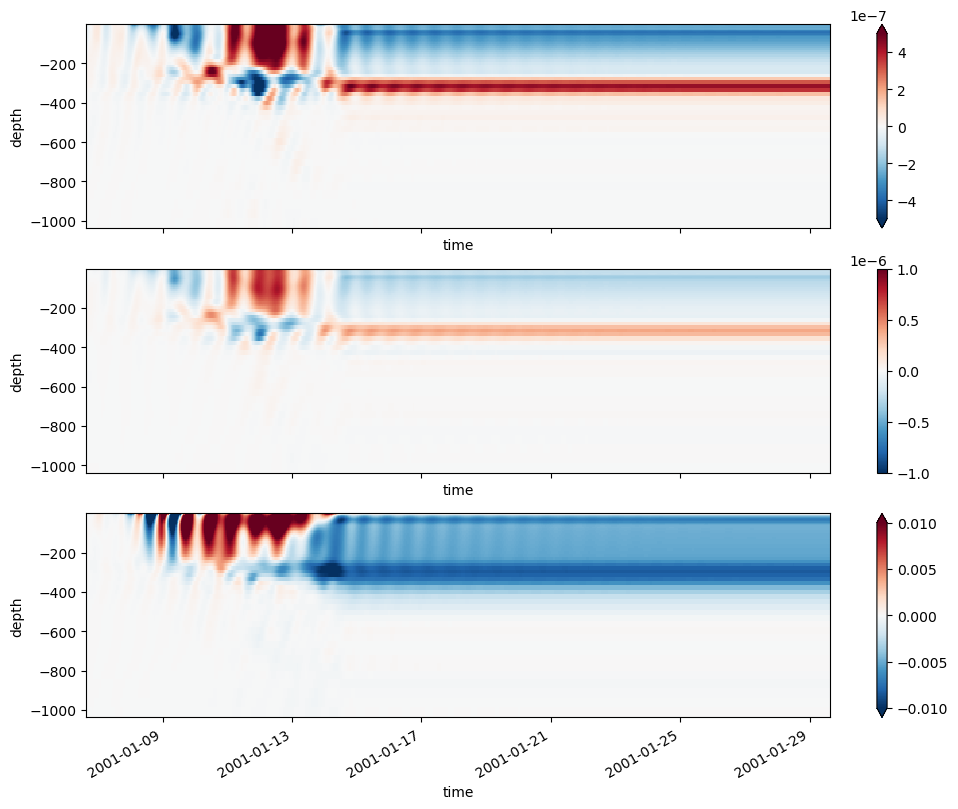

In [97]:
fig,axs = plt.subplots(3,1,figsize=(12,9),sharex=True)
P_mid.plot(ax=axs[0],vmax=5e-7)
P.plot(ax=axs[1],vmax=1e-6)
((PI_M1.mean(['xi_rho','eta_rho'])+PI_M2.mean(['xi_rho','eta_rho'])+PI_M3.mean(['xi_rho','eta_rho'])+PI_M4.mean(['xi_rho','eta_rho']))/4
).plot(ax=axs[2],vmax=1e-2)

Notes on all the reasons this could go wrong:

1/ interpolation at the center of the moorings

2/ interpolation on the cardinal points to get horizontal gradients

3/ not enough mesoscale energy, we are actually looking at noise.

Ways to solve/check these reasons:

1/ Compare selected point from all grid points to interpolated fields. Change interpolation method to find the best estimates

2/ Compare selected point from all grid points to interpolated fields. Change interpolation method to find the best estimates

3/ Wait for Luwei answer. Ask for full field if she ent the filtered one, ask for a square area with stronger mesoscale if it is spatial distribution problem, cry if this it for low frequency flow energy

In [98]:
moorings={'1':M1,'2':M2,'3':M3,'4':M4}
for m in moorings:
    moorings[m] = moorings[m].reset_coords(['lon','lat'])
    moorings[m] = moorings[m].mean(['eta_rho','xi_rho'])
    moorings[m] = moorings[m].assign_coords({'lon':moorings[m].lon,'lat':moorings[m].lat}).expand_dims(['lon','lat'])

In [99]:
def get_mid(moorings,col='usq',method='slinear'):
    """ Interpolate variable at the center  of the mooring triangular array using all moorings measurements.
    ----------------------------------------------------
    Parameters:
    moorings: dict, contains the three moorings xarray datasets
    col:str, variable to interpolate
    ----------------------------------------------------
    Returns:
    ds_mid:DataArray, interpolated variable
    """
    ds_mid=xr.merge([moorings[m][col] for m in moorings])
    #ds_mid[col]=ds_mid[col].interpolate_na(dim='time',max_gap=pd.Timedelta('1D'))
    ds_mid[col]=ds_mid[col].fillna(0).interp(lat=midlat,lon=midlon,method=method)
    ds_mid[col]=ds_mid[col].where(ds_mid[col]!=0)
    return ds_mid[col]
#.assign_coords({'lon':moorings['1'].lon})

In [100]:
# interpolating needed variables to the center of the mooring array
usqf_mid1=get_mid(moorings,col='usq_filtered')  #filtered u squared
vsqf_mid1=get_mid(moorings,col='vsq_filtered')  #filtered v squared
uvf_mid1=get_mid(moorings,col='uv_filtered')    #filtered u*v
uf_mid1=get_mid(moorings,col='u_filtered')  #filtered u
vf_mid1=get_mid(moorings,col='v_filtered')  #filtered v
usq_mid1 =get_mid(moorings,col='usq')   #raw u squared
vsq_mid1 =get_mid(moorings,col='vsq')   #raw v squared

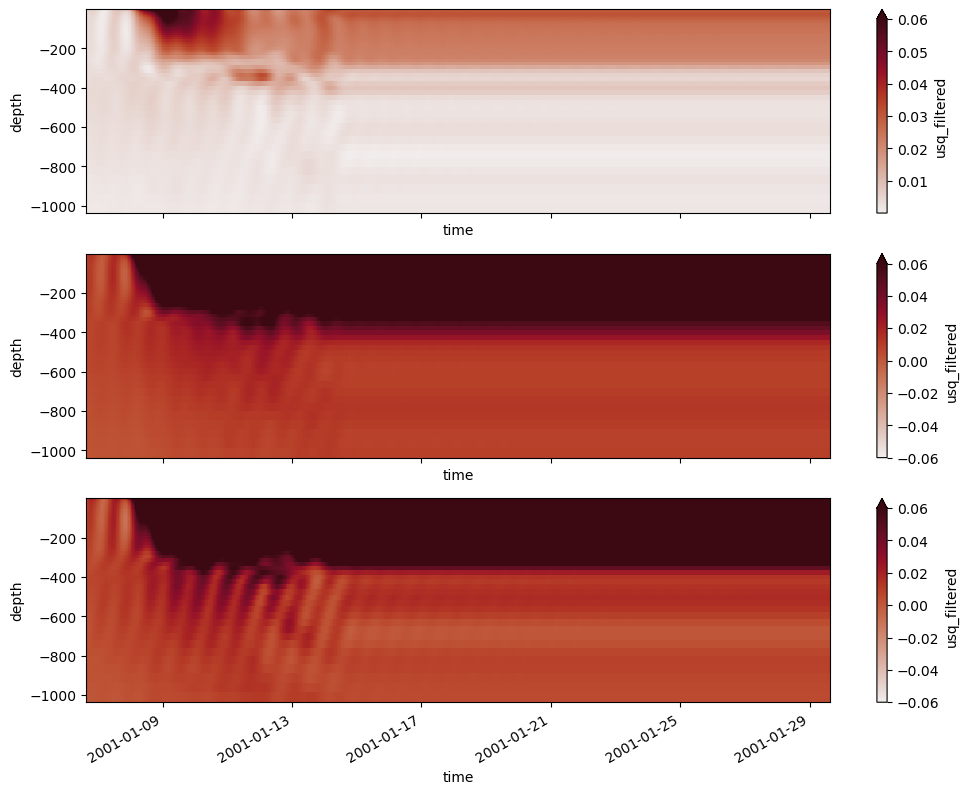

In [104]:
fig,axs = plt.subplots(3,1,figsize=(12,9),sharex=True)
ax=axs[0]
usqf_mid1.plot(ax=ax,cmap=cm.cm.amp,vmax=6e-2)
ax=axs[1]
usqc.plot(ax=ax,cmap=cm.cm.amp,vmax=6e-2)
ax=axs[2]
M_mid.usq_filtered.plot(ax=ax,cmap=cm.cm.amp,vmax=6e-2)

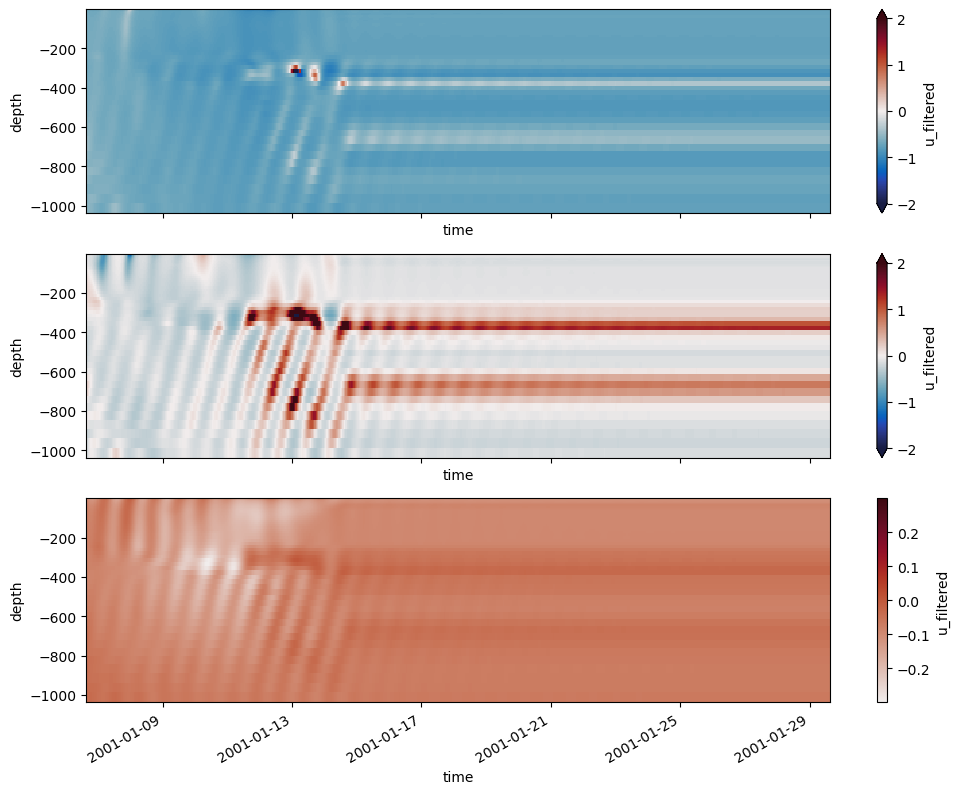

In [105]:
fig,axs = plt.subplots(3,1,figsize=(12,9),sharex=True)
ax=axs[0]
((uf_mid1-M_mid.u_filtered)/M_mid.u_filtered).plot(ax=ax,cmap=cm.cm.balance,vmax=2,vmin=-2)
ax=axs[1]
((uc-M_mid.u_filtered)/M_mid.u_filtered).plot(ax=ax,cmap=cm.cm.balance,vmax=2,vmin=-2)
ax=axs[2]
M_mid.u_filtered.plot(ax=ax,cmap=cm.cm.amp,vmax=None)

In [106]:
# interpolating needed variables to the center of the mooring array
usqf_mid1=get_mid(moorings,col='usq_filtered')  #filtered u squared
vsqf_mid1=get_mid(moorings,col='vsq_filtered')  #filtered v squared
uvf_mid1=get_mid(moorings,col='uv_filtered')    #filtered u*v
uf_mid1=get_mid(moorings,col='u_filtered')  #filtered u
vf_mid1=get_mid(moorings,col='v_filtered')  #filtered v
usq_mid1 =get_mid(moorings,col='usq')   #raw u squared
vsq_mid1 =get_mid(moorings,col='vsq')   #raw v squared

# interpolating needed variables to the center of the mooring array
usqf_mid2=get_mid(moorings,col='usq_filtered',method='cubic')  #filtered u squared
vsqf_mid2=get_mid(moorings,col='vsq_filtered',method='cubic')  #filtered v squared
uvf_mid2=get_mid(moorings,col='uv_filtered',method='cubic')    #filtered u*v
uf_mid2=get_mid(moorings,col='u_filtered',method='cubic')  #filtered u
vf_mid2=get_mid(moorings,col='v_filtered',method='cubic')  #filtered v
usq_mid2 =get_mid(moorings,col='usq',method='cubic')   #raw u squared
vsq_mid2 =get_mid(moorings,col='vsq',method='cubic')   #raw v squared

# interpolating needed variables to the center of the mooring array
usqf_mid3=get_mid(moorings,col='usq_filtered',method='quadratic')  #filtered u squared
vsqf_mid3=get_mid(moorings,col='vsq_filtered',method='quadratic')  #filtered v squared
uvf_mid3=get_mid(moorings,col='uv_filtered',method='quadratic')    #filtered u*v
uf_mid3=get_mid(moorings,col='u_filtered',method='quadratic')  #filtered u
vf_mid3=get_mid(moorings,col='v_filtered',method='quadratic')  #filtered v
usq_mid3 =get_mid(moorings,col='usq',method='quadratic')   #raw u squared
vsq_mid3 =get_mid(moorings,col='vsq',method='quadratic')   #raw v squared

In [107]:
P_mid1 = -((usqf_mid1-uf_mid1**2)*ux_1 + (vsqf_mid1-vf_mid1**2)*vy_1 + (uvf_mid1-uf_mid1*vf_mid1)*(uy_1+vx_1))
P_mid2 = -((usqf_mid2-uf_mid2**2)*ux_1 + (vsqf_mid2-vf_mid2**2)*vy_1 + (uvf_mid2-uf_mid2*vf_mid2)*(uy_1+vx_1))
P_mid3 = -((usqf_mid3-uf_mid3**2)*ux_1 + (vsqf_mid3-vf_mid3**2)*vy_1 + (uvf_mid3-uf_mid3*vf_mid3)*(uy_1+vx_1))

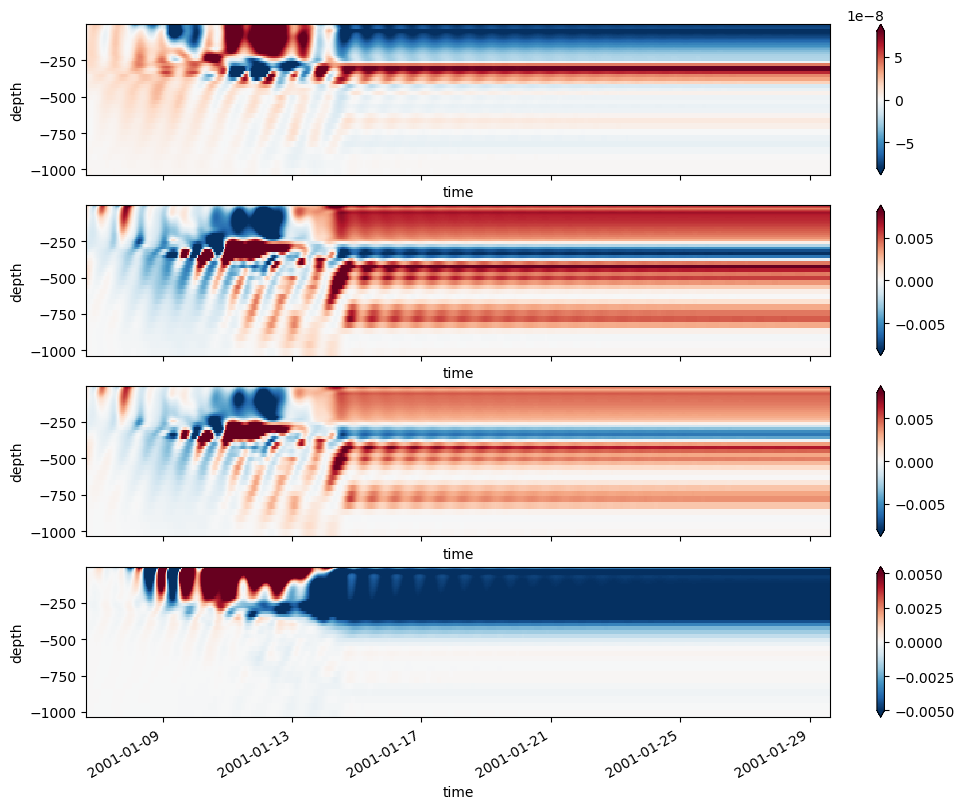

In [121]:
fig,axs = plt.subplots(4,1,figsize=(12,9),sharex=True)
P_mid1.plot(ax=axs[0],vmax=8e-8)
P_mid2.plot(ax=axs[1],vmax=8e-3)
P_mid3.plot(ax=axs[2],vmax=8e-3)
((PI_M1.mean(['xi_rho','eta_rho'])+PI_M2.mean(['xi_rho','eta_rho'])+PI_M3.mean(['xi_rho','eta_rho'])+PI_M4.mean(['xi_rho','eta_rho']))/4
).plot(ax=axs[3],vmax=5e-3)